In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
import tqdm
from typing import List

In [2]:
# Constants
colors = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255, 255, 0),
    (255, 0, 255),
    (0, 255, 255),
    (255, 192, 203),
    (0, 125, 125),
    (255, 125, 125),
    (125, 255, 255),
    (255, 255, 125),
    (125, 255, 125),
    (255, 125, 255),
    (125, 125, 125),
    (125, 125, 0),
    (0, 125, 0)]

4.1.1 

(3) In the given sequence (00-29) pick 15 cells. These cells are traced cells over the
sequence of the 30 images. Indicate your choices with a label/number in the initial
image. These labels are the result from a segmentation operation that successfully
find all the relevant, i.e. 15, cells in the image(s). Develop, apply, explain and motivate
your segmentation procedure.

The segmentation procedure segments all seperate cells in the image. The tracking algorithm (4.1.3) is responsible for finding the 15 relevant cells from the segmentation results. The segmentation procedure itself is quite simple, the images are normalized using normalization from cv2:

cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)  

After that, opening is applied to remove the smallest shapes that are too small to be seperate cells:

cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (9,9)))

A structuring element of (9x9) was selected after carefull testing. This removed all the smallest shapes without corrupting the cells. After the opening, the image was adaptively thresholded using Otsu thresholding: 

cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

This obtained a binary image, which was then used for finding the separate contours:

cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

These contours are the segmented cells. The following code in this notebook will display the relevant visualizations for this procedure.

In [3]:
# Read all 30 images from the controll experiment
images_ctrl = [np.mean(plt.imread(f"images/MTLn3-Ctrl00{'0' + str(i) if i < 10 else i}.tif"), -1).astype(np.uint16) for i in range(30)]

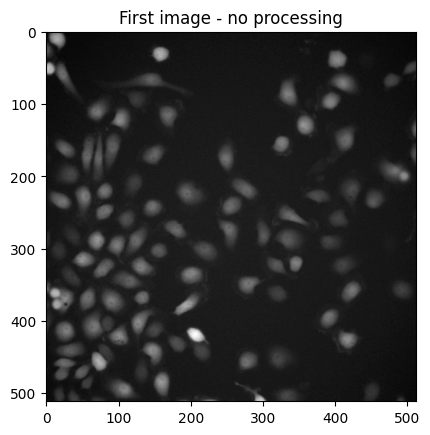

In [4]:
def display_eight(images, start=0):
    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    # Iterate over the image paths and corresponding axes
    for i, (image, ax) in enumerate(zip(images, axes.flat)):
        # Load and display the image on the current axis
        ax.imshow(image, cmap="gray")
        ax.axis('off')
        ax.set_title(f'Image {start+i+1}')

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the figure
    plt.show()

plt.title("First image - no processing")    
plt.imshow(images_ctrl[0], cmap="gray")
plt.show()

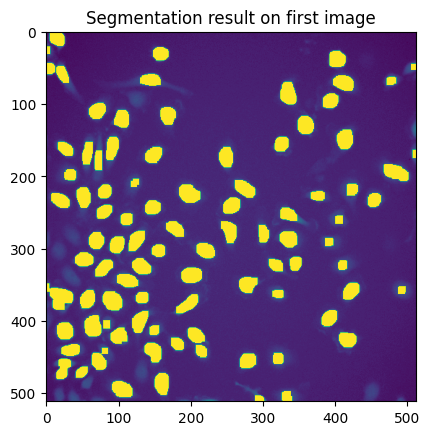

In [5]:
def plot_segmentation(original, contours, number=1, white=False, show=True):
        color_image = np.stack([original.copy()]*3, axis=-1).astype(np.uint16)
        original_image = copy.deepcopy(original)

        for i, (contour, color) in enumerate(zip(contours, colors)):
            plot_color = (255, 255, 255) if white else color
            cv2.drawContours(color_image, [contour], -1, color=plot_color, thickness=cv2.FILLED)
            cx, cy = min(contour, key=lambda l: l[0][0])[0][0], min(contour, key=lambda l: l[0][1])[0][1]

            cv2.putText(color_image, text= str(i+1), org=(cx,cy), fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), 
                        thickness=2, lineType=cv2.LINE_AA)
            cv2.putText(original_image, text= str(i+1), org=(cx,cy), fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), 
                        thickness=2, lineType=cv2.LINE_AA)
        
        if show:
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(color_image)
            axes[1].imshow(original_image, cmap="gray")
            axes[0].set_title(f"Selected cells in segmented image {number}")
            axes[1].set_title(f"Selected cells in original image {number}")
            plt.show()
        
        return color_image, original_image
    
def plot_all_segmentation_white(original, contours):
        original_image = copy.deepcopy(original)

        for contour in contours:
            cv2.drawContours(original_image, [contour], -1, color=(255, 255, 255), thickness=cv2.FILLED)
        
        plt.imshow(original_image)
        plt.title("Segmentation result on first image")
        plt.show()

def segment_cells(image, plot=False):
    """
    Segment different cells in image. Note that many pipelines were tried, and just normalizing and thresholding worked best
    """
    original = image.copy()
    # Normalize
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)    
        
    # Open the image to remove small shapes
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (9,9)))
    
    # Threshold the image
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Convert to unsigned 8-bit integers
    image = image.astype(np.uint8)

    # Find the contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contours
    largest = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    
    # Plot the segmented and labeled images
    if plot:
        plot_segmentation(original, largest)

    return contours

plot_all_segmentation_white(images_ctrl[0], segment_cells(images_ctrl[0], plot=False))

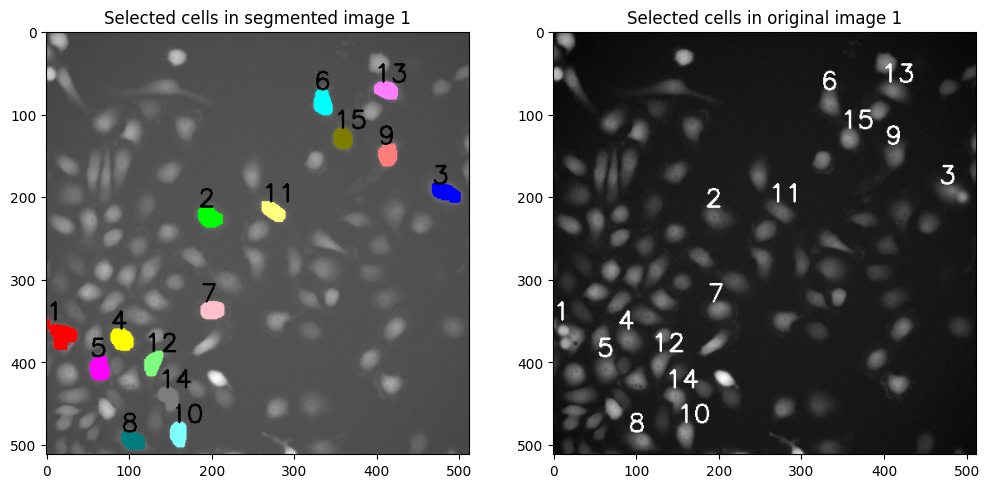

In [6]:
segment_cells(images_ctrl[0], plot=True)
pass

### 4.1.2
Five labeled cells, with numbers (2, 7, 9, 11, 15) are manually tracked to form a validation procedure. These specific cells were selected on two criteria:

- The cells do not divide in the time-lapse of 30 images
- The cells are clearly separable in the first image
- We were sure that our manual tracking was correct (some cells interact in a way that makes it impossible to be entirely sure which ones match between frames)

The procedure for this is straightforward; the cells are tracked one image at a time. The center coordinates of the five cell are estimated in the last image. The validation algorithm will then check the outcome of the automatic tracking of the five cells (labeled 2, 7, 9, 11, 15) by comparing the mean coordinate of the resulting cell with the manually estimated mean coordinate. Some small error will be allowed, since this could result from a slightly wrong estimation of the mean coordinate. However, if the error exceeds a dynamic threshold in either the x or y direction, the cell tracking was off. The dynamic threshold will be set to 0.25 * diameter of the cell in the given direction. In this way, large cells can have a larger manual error by estimating the mean. The hand-labeled results are stored in tuples of coordinates of the form [((x_cell2_image1, y_cell2_image1), (x_cell2_image30, y_cell1_image30)), ...]. The first image (number 1) is excluded, since it seems to contain overlapping cells, and that makes it hard to track manually. Image 5 was discarded, because it divides into two cells after image 20, so our tracking algorithm will track only one of the resulting cells. 

Our validation algorithm only shows the number of correctly tracked cells. We could show the Euclidean distance between the true cell and predicted cell in image 30, but in our opinion this is not descriptive, since one mistake between two images can lead to a large distance in the true cell and predicted cell, which does not make the entire algorithm more wrong, just the small mistake between the two images.

In [8]:
def validate_results(original_cells, pred_cells):
    """
    Coordinates in image 30 (manually estimated)
        2: (194, 220)
        7: (217, 362)
        9: (371, 135)
        11: (277, 212)
        15: (346, 108)
    """
    manual_indices = [1, 6, 8, 10, 14]
    
    # Select the 5 manually tracked cells. They have indices [1, 2, 3, 5, 6], and labels [index + 1 for index in indices].    
    predictions = [p for p in pred_cells if p.idx in manual_indices]
    originals = [p for p in original_cells if p.idx in manual_indices]
    
    true_coordinates = [(194, 220),
                        (217, 362),
                        (371, 135),
                        (277, 212),
                        (346, 108)]

    correct = []
    for orig, true, pred in zip(originals, true_coordinates, predictions):
        err_x = abs(true[0] - pred.mean_x)
        err_y = abs(true[1] - pred.mean_y)
        print(f"Error X and Y: ({round(err_x, 2)}, {round(err_y, 2)}). Correct: {bool((err_x < 0.25 * orig.width and err_y < 0.25 * orig.height))}")
        correct.append(bool(err_x < 0.25 * orig.width and err_y < 0.25 * orig.height))
        
    return sum(correct) / len(correct)

(3) Develop an algorithm that can trace the cells over the time-lapse sequence. It is
important is to make a choice for criteria by which you can determine that a cell in a
next frame is the same cell in the current frame. Your algorithm is based on that
criterion, or those criteria. This should be clearly stated in the explanation of the
algorithm

The algorithm developed iteratively finds the best match for the 15 selected cells in the previous frame. This means that 15 cells are selected once (in image 1). After this, the 15 best matches with image 1 will be found in image 2, after which the 15 best matches with image 3 are found in image 2. This is relatively straightforward.

However, determining the closest match out of 50-150 segmentation results is not. This operation is fully dependent on the distance function that determines the relative distance between two cells, in Cell.distance. Note that this function is relative, so it does not have to express a spatial distance. 

For the first version of the algorithm, the distance function was simply the euclidean distance between the mean positions of the two cells. The results can be seen below.


In [9]:
class Cell:
    def __init__(self, contour, idx):
        self.idx = idx
        self.contour = contour
        self.mean_x = np.mean(contour[:, :, 0])
        self.mean_y = np.mean(contour[:, :, 1])
        self.area = cv2.contourArea(contour)
        self.width = max(contour[:, :, 0]) - min(contour[:, :, 0])
        self.height = max(contour[:, :, 1]) - min(contour[:, :, 1])
        
    def features(self):
        return  np.array([self.contour,
                          self.mean_x,
                          self.mean_y,
                          self.area,
                          self.width,
                          self.height]).astype(np.uint16)
    
    def to_contour(self):
        return self.contour
    
    def distance(self, cell):
        return self.euclidean_distance(cell)
    
    def euclidean_distance(self, cell):
        """
        Return the Squared Euclidean Distance between this and another cell
        Since it is a relative distance, no square root is applied
        """
        return abs(self.mean_x - cell.mean_x) ** 2 + abs(self.mean_y - cell.mean_y) ** 2
    
    def copy(self, idx):
        new = copy.deepcopy(self)
        new.idx = idx
        return new
    
    def __str__(self):
        return f"Cell {self.idx}, mean {self.mean_x, self.mean_y}\n"
         
    
def trace_cells_over_image(images, plot=False):
    # Segment the first image and create Cell objects
    segmentations_first_image = segment_cells(images[0], plot=False)
    sorted_segmentations = sorted(segmentations_first_image, key=cv2.contourArea, reverse=True)
    
    segmented_cells = [Cell(cell, i) for i, cell in enumerate(sorted_segmentations)]
        
    # Select the 15 largest cells from the first image
    tracking_cells = segmented_cells[:15]
    
    # Apply the tracking algorithm. 
    # Segment all images
    segmentation_all_images = [tracking_cells] + [[Cell(cell, i) for i, cell in enumerate(segment_cells(images[j], plot=False))] for j in range(1, len(images))]
    
    # Select the 15 cells iteratively by computing the distance for each cell in the next image
    for i in range(len(segmentation_all_images) - 1):
        current_seg = segmentation_all_images[i]
        next_seg = segmentation_all_images[i + 1]
        new_next_seg = []
        
        # Find closest match for each cell
        for cell in current_seg:
            match = min(next_seg, key=lambda l: cell.distance(l))
            new_next_seg.append(match.copy(cell.idx))
        
        segmentation_all_images[i + 1] = new_next_seg
        
    colored_results = []
    gray_results = []
    
    for i in range(len(segmentation_all_images)):
        colored, gray = plot_segmentation(images[i], [c.to_contour() for c in segmentation_all_images[i]], number=i+1, show=plot)
        colored_results.append(colored)
        gray_results.append(gray)
    
    return colored_results, gray_results, tracking_cells, [c for c in segmentation_all_images[-1]]

4.1.3: Execute first version of algorithm

In [11]:
# Bring it all together
colored_results, gray_results, original_cells, predicted_cells = trace_cells_over_image(images_ctrl, plot=False)
validate_results(original_cells, predicted_cells)

Error X and Y: (0.55, 0.97). Correct: True
Error X and Y: (0.42, 1.65). Correct: True
Error X and Y: (2.89, 0.89). Correct: True
Error X and Y: (0.46, 1.61). Correct: True
Error X and Y: (0.68, 2.57). Correct: True


1.0

4.1.3

As we can see, all five cells are tracked correctly. We can try different distance functions to tune our algorithm, which in this case might not be wise since our validation returns 1.0, but in reality will often be better. In fact, many other cells are wrongly tracked it seems.

In [12]:
def new_distance(self, cell):
    """
    Create a new distance function that takes size into account.
    We will eliminate any cells that differ too much in size by adding a large amount to the distance
    """
    if not (0.75 < self.area / cell.area < 1.25):
        return self.euclidean_distance(cell) + 1000000

    return self.euclidean_distance(cell)

# Change (monkeypatch) the new distance function in the Cell object
Cell.distance = new_distance

# Execute algorithm again
colored_results, gray_results, original_cells, predicted_cells = trace_cells_over_image(images_ctrl, plot=False)
validate_results(original_cells, predicted_cells)

Error X and Y: (0.55, 0.97). Correct: True
Error X and Y: (89.75, 13.78). Correct: False
Error X and Y: (2.89, 0.89). Correct: True
Error X and Y: (0.46, 1.61). Correct: True
Error X and Y: (0.68, 2.57). Correct: True


0.8

For the report, we will therefore use the first (euclidean) distance function, since it seems to work best on our validation set.

4.1.4

The algorithm is applied to both set A and B. All intermediary results are stored.

In [15]:
# Load the images
images_A = [np.mean(plt.imread(f"images/MTLn3-Ctrl00{'0' + str(i) if i < 10 else i}.tif"), -1).astype(np.uint16) for i in range(30)]
images_B = [np.mean(plt.imread(f"images/MTLn3+EGF00{'0' + str(i) if i < 10 else i}.tif"), -1).astype(np.uint16) for i in range(30)]

# Define results folders
results_a = "results/results-A/"
results_b = "results/results-B/"

# Apply the algorithm
colored_results_a, gray_results_a, _, _ = trace_cells_over_image(images_A, plot=False)
colored_results_b, gray_results_b, _, _ = trace_cells_over_image(images_B, plot=False)

# Save all results in correct folders
for i in range(len(images_A)):
    plt.imsave(f"{results_a}colored/{i}.png", colored_results_a[i].astype(np.uint8))
    plt.imsave(f"{results_a}gray/{i}.png", gray_results_a[i].astype(np.uint8))
    plt.imsave(f"{results_b}colored/{i}.png", colored_results_b[i].astype(np.uint8))
    plt.imsave(f"{results_b}gray/{i}.png", gray_results_b[i].astype(np.uint8))